# Emergency Facilities Location Prediction

**Step 1:** Prepare Toronto neigbourhood data

In [1]:
import pandas as pd
import numpy as np
import requests

get wiki page  
read table with data into dataframe  
rename column  
remove 'Not Assigned' boroughs  
replace 'Not Assigned' neighborhoods with boroughs values  
group neighbourhoods for the same borough

In [2]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki_page = requests.get(wiki_url)
codes_df_list = pd.read_html(io = wiki_page.text, attrs = {'class': 'wikitable'})
codes_df_0 = codes_df_list[0]
codes_df_1 = codes_df_0.rename(columns = {'Postcode': 'PostalCode'})
codes_df_2 = codes_df_1[codes_df_1['Borough'] != 'Not assigned']
codes_df_2['Neighbourhood'] = np.where(codes_df_2['Neighbourhood'] == 'Not assigned', codes_df_2['Borough'], codes_df_2['Neighbourhood'])
neighborhood_df = codes_df_2.groupby(['PostalCode', 'Borough'])['Neighbourhood'].apply(lambda v: ', '.join(v)).reset_index()
neighborhood_df.head()

c:\users\omuko\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


**Step 2:** Prepare neighborhood geo data

read geo data  
rename column

In [3]:
geo_df = pd.read_csv('https://cocl.us/Geospatial_data')
geo_df = geo_df.rename(columns = {'Postal Code': 'PostalCode'})

In [4]:
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


combine neighborhood and geo data

In [5]:
data_with_geo = pd.merge(neighborhood_df, geo_df[['PostalCode', 'Latitude', 'Longitude']], on = 'PostalCode')

In [6]:
data_with_geo.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


**Step 3:** Prepare emergency statistic data

In [7]:
import urllib
import json

get excel file url from open data portal

In [8]:
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show'
params = { 'id': 'c21f3bd1-e016-4469-abf5-c58bb8e8b5ce'}
response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding='utf-8'))
package = json.loads(response.read())
xls_url = package['result']['resources'][0]['url']
print(xls_url)

http://opendata.toronto.ca/it/com/TPS_Incident_Data_2010-2019.xlsx


get excel file

In [9]:
!wget http://opendata.toronto.ca/it/com/TPS_Incident_Data_2010-2019.xlsx

--2020-02-12 08:04:55--  http://opendata.toronto.ca/it/com/TPS_Incident_Data_2010-2019.xlsx
Resolving opendata.toronto.ca (opendata.toronto.ca)... 206.130.170.86
Connecting to opendata.toronto.ca (opendata.toronto.ca)|206.130.170.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97534332 (93M)
Saving to: ‘TPS_Incident_Data_2010-2019.xlsx’

100%[======================================>] 97,534,332   668KB/s   in 2m 31s 

2020-02-12 08:07:27 (630 KB/s) - ‘TPS_Incident_Data_2010-2019.xlsx’ saved [97534332/97534332]



since load annual data from xlsx in the list of dataframes takes ~ 3 minutes per sheet (overall 30 minutes) it was convertet to 10 csv files which are loaded in less than a minute

In [8]:
df_list = []
for year in range(2010, 2020):
    year_df = pd.read_csv('TPS_Incident_Data_' + str(year) + '.csv')
    print(str(year) + ' loaded')
    df_list.append(year_df)

2010 loaded
2011 loaded
2012 loaded
2013 loaded
2014 loaded
2015 loaded
2016 loaded
2017 loaded
2018 loaded
2019 loaded


**Step 4:** combine data

transform and merge statistical data, pay attention that 2010, 2011 and 2017 year data have different columns naming

In [9]:
df_temp = []
year = 2010
for df in df_list:
    df_t = df.drop(columns=['ID', 'Dispatch_Time', 'Incident_Type', 'Priority_Number'])
    if year in [2010, 2011, 2017]:
        df_t = df_t.groupby(['FSA']).sum().reset_index().rename(columns = {'FSA': 'PostalCode', 'Units_Arrived_At_Scene': str(year)})
    else:
        df_t = df_t.groupby(['Forward_Sortation_Area']).sum().reset_index().rename(columns = {'Forward_Sortation_Area': 'PostalCode', 'Units_Arrived_At_Scene': str(year)})
    df_temp.append(df_t)
    data_with_geo = pd.merge(data_with_geo, df_t[['PostalCode', str(year)]], on = 'PostalCode', how = 'left')
    year = year + 1

In [10]:
data_with_geo.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,3303.0,3651.0,3781.0,4020.0,4109.0,4300.0,4497.0,4581.0,4810.0,4890.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1742.0,1874.0,1854.0,1881.0,1982.0,1935.0,2018.0,2106.0,2225.0,2353.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4217.0,4762.0,4810.0,4780.0,4949.0,5408.0,5835.0,5606.0,5870.0,5620.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,2073.0,2444.0,2298.0,2190.0,2419.0,2293.0,2364.0,2449.0,2585.0,2546.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1833.0,2012.0,2072.0,2159.0,2348.0,2288.0,2327.0,2529.0,2655.0,2628.0


In [11]:
data_with_geo.shape

(103, 15)

some rows have missing values

In [12]:
data_with_geo.loc[data_with_geo['PostalCode'] == 'M7A']

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
85,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


we can either replace them with mean values either ignore

In [13]:
temp = data_with_geo.loc[data_with_geo['2010'].isnull() == False]

prepare data to further process

In [14]:
agg_dict = {'Latitude':'mean', 'Longitude':'mean', '2010':'sum', '2011':'sum', '2012': 'sum', '2013':'sum', '2014':'sum', '2015':'sum', '2016':'sum', '2017':'sum', '2018':'sum', '2019':'sum'}
data_df = temp.drop(columns = ['PostalCode', 'Neighbourhood']).groupby('Borough').agg(agg_dict).reset_index()

In [15]:
data_df.shape

(10, 13)

In [16]:
data_df

,Borough,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Central Toronto,43.701980,-79.398954,12773.0,14197.0,14453.0,14796.0,16127.0,15645.0,16719.0,16869.0,17599.0,18107.0
1,Downtown Toronto,43.656058,-79.384818,35965.0,38967.0,40856.0,43223.0,45618.0,47672.0,52299.0,54141.0,58866.0,61858.0
2,East Toronto,43.671110,-79.325428,10684.0,10901.0,10893.0,11439.0,11430.0,11376.0,11658.0,11900.0,13231.0,13488.0
3,East York,43.700303,-79.335851,11619.0,12054.0,12129.0,12952.0,13564.0,13493.0,13827.0,14000.0,14398.0,14521.0
4,Etobicoke,43.659333,-79.542967,26935.0,29949.0,29932.0,30493.0,31299.0,31173.0,32793.0,33821.0,35678.0,35529.0
5,North York,43.750727,-79.429338,53327.0,58006.0,58122.0,59289.0,61537.0,61756.0,65029.0,65819.0,69280.0,68274.0
6,Queen's Park,43.667856,-79.532242,2470.0,2908.0,2956.0,2927.0,3045.0,3182.0,3351.0,3268.0,3431.0,3499.0
7,Scarborough,43.766229,-79.249085,44765.0,49333.0,49095.0,51567.0,53077.0,53587.0,55006.0,56499.0,59021.0,58621.0
8,West Toronto,43.652653,-79.449290,19022.0,20759.0,21421.0,21864.0,23432.0,23709.0,24239.0,24539.0,27084.0,27139.0
9,York,43.690797,-79.472633,16776.0,18099.0,17522.0,18102.0,18930.0,18814.0,19427.0,19553.0,20799.0,20980.0


**Step 5:** visualize and analyze data

In [17]:
import folium
from folium.plugins import HeatMapWithTime

In [18]:
print(folium.__version__)

0.10.1


In [19]:
import matplotlib
import matplotlib.pyplot as plt

In [20]:
print(matplotlib.__version__)

3.1.3


In [21]:
x_years = [*range(2010, 2020)]
x_years

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

visualize annual growth

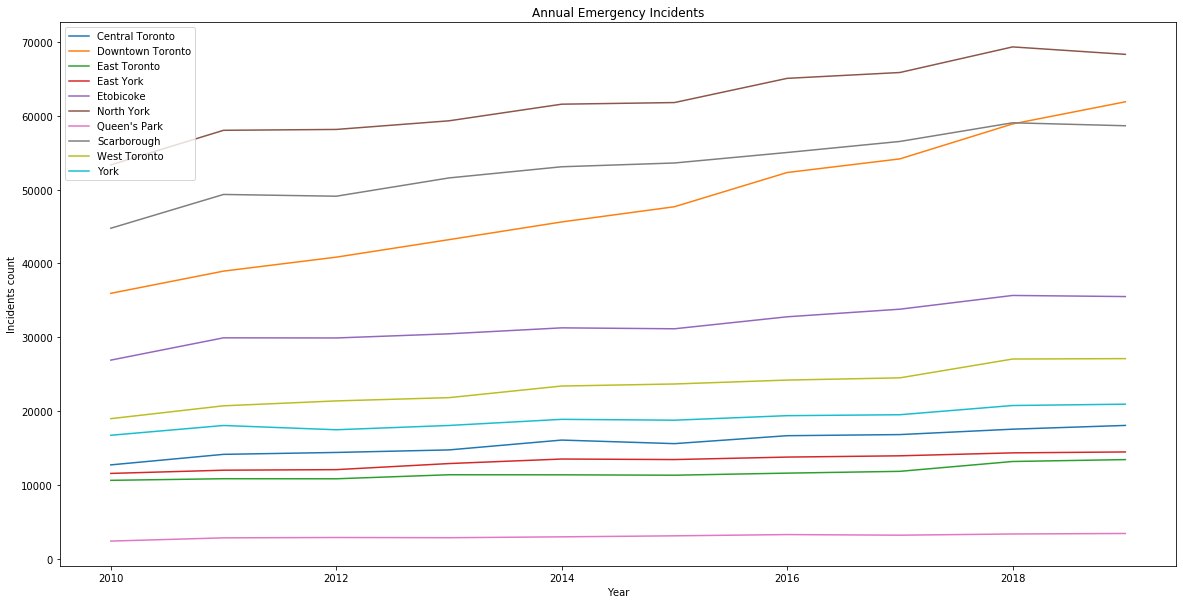

In [22]:
fig, ax = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(20)

for index, row in data_df.iterrows():
    ax.plot(x_years, [*row[3:13]], label = row['Borough'])

ax.set(xlabel='Year', ylabel='Incidents count', title='Annual Emergency Incidents')
plt.legend()

plt.show()

as we can observe incident growth is linear, so we can use linear regression for values prediction  
the fastest growth is observed in Downtown Toronto

In [23]:
tor_lat = 43.653963
tor_lon = -79.387207

In [24]:
normalizer = data_df.drop(['Borough', 'Latitude', 'Longitude'], axis = 1).max(numeric_only = True).max()

In [25]:
normalizer

69280.0

prepare data for heatmap

In [26]:
values = []
for year in x_years:
    temp_list = [list(i) for i in zip(data_df['Latitude'], data_df['Longitude'], data_df[str(year)].div(normalizer))]
    values.append(temp_list)

In [27]:
tor_map = folium.Map(location=[tor_lat, tor_lon], zoom_start=11)

In [28]:
HeatMapWithTime(data = values, index = x_years, radius = 15, gradient = {0.2: 'green', 0.4: 'orange', 1: 'red'}, min_opacity = 0.5, max_opacity = 1, use_local_extrema = True).add_to(tor_map)

In [29]:
tor_map

**Step 6:** predict growth for the next decade

In [33]:
from sklearn.linear_model import LinearRegression

In [49]:
regressions = []

for index, row in data_df.iterrows():
    y = np.array([*row[3:13]]).reshape(-1, 1)
    x = np.array([*range(2010, 2020)]).reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(x, y)
    regressions.append(lr)

In [72]:
for year in range(2020, 2030):
    predict = []
    for lr in regressions:
        pr_ar = lr.predict([[year]])
        pr_val = pr_ar[0][0]
        val = round(pr_val, 1)
        predict.append(val)
    data_df[str(year)] = predict

In [68]:
data_df.drop([str(el) for el in range(2020, 2030)], axis = 1, inplace = True)

In [73]:
data_df

,Borough,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029
0,Central Toronto,43.701980,-79.398954,12773.0,14197.0,14453.0,14796.0,16127.0,15645.0,16719.0,...,18701.4,19241.9,19782.5,20323.0,20863.5,21404.0,21944.6,22485.1,23025.6,23566.1
1,Downtown Toronto,43.656058,-79.384818,35965.0,38967.0,40856.0,43223.0,45618.0,47672.0,52299.0,...,63547.7,66384.3,69220.9,72057.5,74894.1,77730.7,80567.3,83403.8,86240.4,89077.0
2,East Toronto,43.671110,-79.325428,10684.0,10901.0,10893.0,11439.0,11430.0,11376.0,11658.0,...,13272.8,13558.8,13844.7,14130.7,14416.7,14702.6,14988.6,15274.5,15560.5,15846.5
3,East York,43.700303,-79.335851,11619.0,12054.0,12129.0,12952.0,13564.0,13493.0,13827.0,...,15070.2,15400.1,15730.0,16059.9,16389.8,16719.7,17049.7,17379.6,17709.5,18039.4
4,Etobicoke,43.659333,-79.542967,26935.0,29949.0,29932.0,30493.0,31299.0,31173.0,32793.0,...,36549.1,37419.8,38290.6,39161.3,40032.0,40902.7,41773.4,42644.1,43514.9,44385.6
5,North York,43.750727,-79.429338,53327.0,58006.0,58122.0,59289.0,61537.0,61756.0,65029.0,...,71022.7,72655.2,74287.8,75920.3,77552.8,79185.3,80817.8,82450.3,84082.9,85715.4
6,Queen's Park,43.667856,-79.532242,2470.0,2908.0,2956.0,2927.0,3045.0,3182.0,3351.0,...,3633.4,3729.7,3826.0,3922.3,4018.6,4114.9,4211.3,4307.6,4403.9,4500.2
7,Scarborough,43.766229,-79.249085,44765.0,49333.0,49095.0,51567.0,53077.0,53587.0,55006.0,...,61069.3,62526.1,63982.9,65439.6,66896.4,68353.2,69810.0,71266.7,72723.5,74180.3
8,West Toronto,43.652653,-79.449290,19022.0,20759.0,21421.0,21864.0,23432.0,23709.0,24239.0,...,27998.1,28848.6,29699.0,30549.4,31399.8,32250.3,33100.7,33951.1,34801.5,35652.0
9,York,43.690797,-79.472633,16776.0,18099.0,17522.0,18102.0,18930.0,18814.0,19427.0,...,21258.5,21687.3,22116.1,22544.9,22973.7,23402.5,23831.3,24260.0,24688.8,25117.6


In [125]:
data_df.to_csv('data.csv')

**Step 7:** visualize predicted growth

In [ ]:
pr_years = [*range(2010, 2030)]

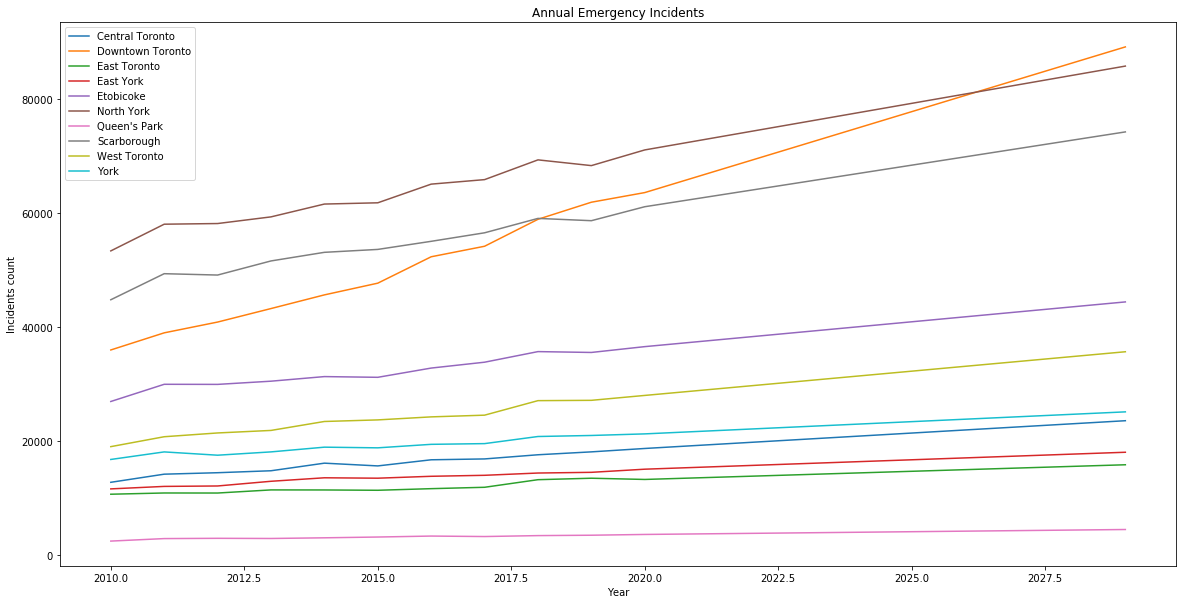

In [76]:
fig, ax = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(20)

for index, row in data_df.iterrows():
    ax.plot(pr_years, [*row[3:23]], label = row['Borough'])

ax.set(xlabel='Year', ylabel='Incidents count', title='Annual Emergency Incidents')
plt.legend()

plt.show()

In [78]:
new_normalizer = data_df.drop(['Borough', 'Latitude', 'Longitude'], axis = 1).max(numeric_only = True).max()

In [80]:
pr_values = []
for year in pr_years:
    temp_list = [list(i) for i in zip(data_df['Latitude'], data_df['Longitude'], data_df[str(year)].div(new_normalizer))]
    pr_values.append(temp_list)
tor_map = folium.Map(location=[tor_lat, tor_lon], zoom_start=11)
HeatMapWithTime(data = pr_values, index = pr_years, radius = 15, gradient = {0.2: 'green', 0.4: 'orange', 1: 'red'}, min_opacity = 0.5, max_opacity = 1, use_local_extrema = True).add_to(tor_map)
tor_map

**Step 8:** get data on existing emergency service locations

In [83]:
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=hospital'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    tor_lat, 
    tor_lon, 
    5000, 
    1)

In [84]:
results = requests.get(url).json()['response']['venues']
results

[{'id': '4ad4c064f964a5206ef820e3',
  'name': 'The Hospital for Sick Children (SickKids)',
  'location': {'address': '555 University Ave.',
   'crossStreet': 'at Gerrard St.',
   'lat': 43.657498668962646,
   'lng': -79.3865121609307,
   'labeledLatLngs': [{'label': 'display',
     'lat': 43.657498668962646,
     'lng': -79.3865121609307}],
   'distance': 397,
   'postalCode': 'M5G 1X8',
   'cc': 'CA',
   'city': 'Toronto',
   'state': 'ON',
   'country': 'Canada',
   'formattedAddress': ['555 University Ave. (at Gerrard St.)',
    'Toronto ON M5G 1X8',
    'Canada']},
  'categories': [{'id': '4bf58dd8d48988d196941735',
    'name': 'Hospital',
    'pluralName': 'Hospitals',
    'shortName': 'Hospital',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/medical_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1581514425',
  'hasPerk': False}]

get category id for medical facilities

In [87]:
category_id = results[0]['categories'][0]['id']
category_id

'4bf58dd8d48988d196941735'

In [88]:
def call_api(lat, lon, category_id, radius = 1000, limit = 100):
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lon, 
        radius, 
        limit,
        category_id)
            
    return(requests.get(url).json()['response']['venues'])

In [89]:
loc_df = pd.DataFrame(columns = ['Name', 'Borough', 'Latitude', 'Longitude'])

In [92]:
for index, row in data_df.iterrows():
    responces = call_api(row['Latitude'], row['Longitude'], category_id, radius = 5000, limit = 1000)
    for resp in responces:
        lat = resp['location']['lat']
        lon = resp['location']['lng']
        name = resp['name']
        loc_df.loc[len(loc_df)] = [name, row['Borough'], lat, lon]

In [94]:
loc_df.head()

,Name,Borough,Latitude,Longitude
0,Peter Munk Building,Central Toronto,43.658425,-79.389234
1,Sunnybrook Hospital,Central Toronto,43.721838,-79.375978
2,The Hospital for Sick Children (SickKids),Central Toronto,43.657499,-79.386512
3,Women's College Hospital,Central Toronto,43.661491,-79.387602
4,60 Murray Street,Central Toronto,43.658128,-79.391242


In [95]:
loc_df.shape

(351, 4)

**Step 9:** put data on map

In [126]:
med_map = folium.Map(location=[tor_lat, tor_lon], zoom_start=11)
for lat, lng, name in zip(loc_df['Latitude'], loc_df['Longitude'], loc_df['Name']):
    label = name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='red',
        #color=bor_col.get(borough),
        parse_html=False).add_to(med_map)

folium.CircleMarker(
        [43.656058, -79.384818],
        radius=50,
        popup=folium.Popup('Downtown', parse_html=True),
        color='green',
        parse_html=False).add_to(med_map)
    
med_map

In [112]:
med_agg = loc_df.drop(columns = ['Name', 'Longitude']).groupby('Borough').count().rename(columns = {'Latitude': 'count'}).reset_index()

In [113]:
med_agg

,Borough,count
0,Central Toronto,49
1,Downtown Toronto,50
2,East Toronto,50
3,East York,48
4,Etobicoke,9
5,North York,47
6,Queen's Park,13
7,Scarborough,18
8,West Toronto,50
9,York,17


In [114]:
med_agg = pd.merge(med_agg, data_df[['Borough', 'Latitude', 'Longitude']], on = 'Borough')

In [115]:
med_agg

,Borough,count,Latitude,Longitude
0,Central Toronto,49,43.701980,-79.398954
1,Downtown Toronto,50,43.656058,-79.384818
2,East Toronto,50,43.671110,-79.325428
3,East York,48,43.700303,-79.335851
4,Etobicoke,9,43.659333,-79.542967
5,North York,47,43.750727,-79.429338
6,Queen's Park,13,43.667856,-79.532242
7,Scarborough,18,43.766229,-79.249085
8,West Toronto,50,43.652653,-79.449290
9,York,17,43.690797,-79.472633


In [108]:
med_norm = med_agg.max(numeric_only = True).max()

In [109]:
med_norm

50

In [119]:
from folium.plugins import HeatMap

In [124]:
med_values = [list(i) for i in zip(med_agg['Latitude'], med_agg['Longitude'], med_agg['count'].div(med_norm))]
med_map = folium.Map(location=[tor_lat, tor_lon], zoom_start=11)
HeatMap(data = med_values, radius = 15, gradient = {0.2: 'green', 0.4: 'orange', 1: 'red'}, min_opacity = 0.5, max_opacity = 1, use_local_extrema = True).add_to(med_map)
med_map